In [1]:
import argparse
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from chainconsumer import ChainConsumer
from haiku._src.nets.resnet import ResNet18
from jax.lib import xla_bridge
# from jax_lensing.configs import Porqueres_2023
from config import Porqueres_2023
from jax_lensing.model import make_full_field_model
from numpyro import distributions as dist
from numpyro.handlers import condition, seed, trace
from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from sbi_lens.normflow.train_model import TrainModel
from tqdm import tqdm
from lenstools import ConvergenceMap
import astropy.units as u
import itertools

np.complex = complex
np.float = float

print(xla_bridge.get_backend().platform)

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gpu


### LPT Model

In [2]:
######## LPT MODEL ########
# setting
fiducial_cosmology = Porqueres_2023.fiducial_cosmology
box_size = Porqueres_2023.box_size
box_shape = Porqueres_2023.box_shape
field_size = Porqueres_2023.field_size
field_npix = Porqueres_2023.field_npix
nz_shear = Porqueres_2023.nz_shear
sigma_e = Porqueres_2023.sigma_e
priors = Porqueres_2023.priors
nbins = len(nz_shear)
dim = len(priors)

lensing_model = jax.jit(
    make_full_field_model(
        field_size=field_size,
        field_npix=field_npix,
        box_size=box_size,
        box_shape=box_shape,
    )
)


# Define the probabilistic model
def model():
    """
    This function defines the top-level forward model for our observations
    """
    # Sampling initial conditions
    initial_conditions = numpyro.sample(
        "initial_conditions", dist.Normal(jnp.zeros(box_shape), jnp.ones(box_shape))
    )

    Omega_b = fiducial_cosmology.Omega_b
    h = fiducial_cosmology.h
    n_s = fiducial_cosmology.n_s
    w0 = fiducial_cosmology.w0
    Omega_c = numpyro.sample("Omega_c", priors["Omega_c"])
    sigma8 = numpyro.sample("sigma8", priors["sigma8"])

    cosmo = jc.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        sigma8=sigma8,
        h=h,
        n_s=n_s,
        w0=w0,
        wa=0.0,
        Omega_k=0.0,
    )

    # Generate random convergence maps
    convergence_maps, _ = lensing_model(cosmo, nz_shear, initial_conditions)

    # Apply noise to the maps (this defines the likelihood)
    observed_maps = [
        numpyro.sample(
            "kappa_%d" % i,
            dist.Normal(
                k,
                sigma_e
                / jnp.sqrt(
                    nz_shear[i].gals_per_arcmin2 * (field_size * 60 / field_npix) ** 2
                ),
            ),
        )
        for i, k in enumerate(convergence_maps)
    ]

    return observed_maps

### Fiducial Model

/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/linkhome/rech/genkqu01/ufa23yn/.local/lib/python3.10/site-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/linkhome/rech/genkqu01/uf

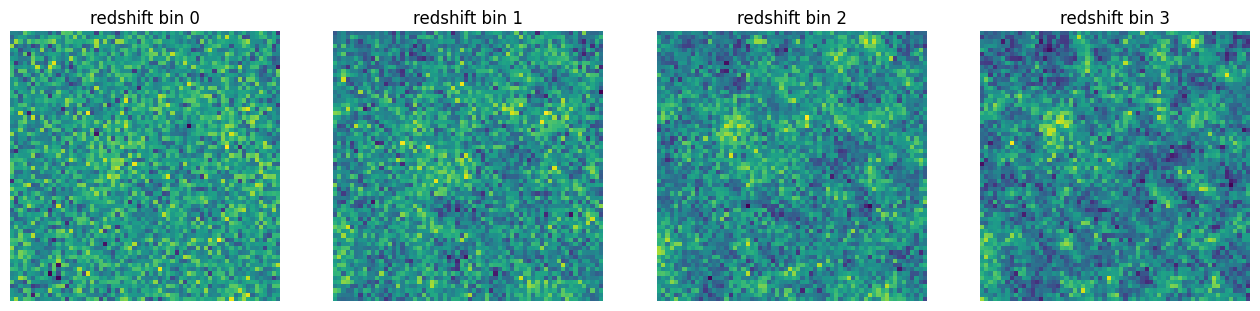

In [3]:
######### FIDUCIAL MODEL ##########
# condition the model on a given set of parameters
fiducial_model = condition(
    model, {"Omega_c": fiducial_cosmology.Omega_c, "sigma8": fiducial_cosmology.sigma8}
)

# sample a mass map and save corresponding true parameters
model_trace = trace(seed(fiducial_model, jax.random.PRNGKey(1234))).get_trace()

m_data = jnp.stack([model_trace["kappa_%d" % i]["value"] for i in range(4)], axis=-1)

truth = [fiducial_cosmology.Omega_c, fiducial_cosmology.sigma8]

plt.figure(figsize=[16,4])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title('redshift bin %d'%i)
    plt.imshow(m_data[:,:,i])
    plt.axis('off')

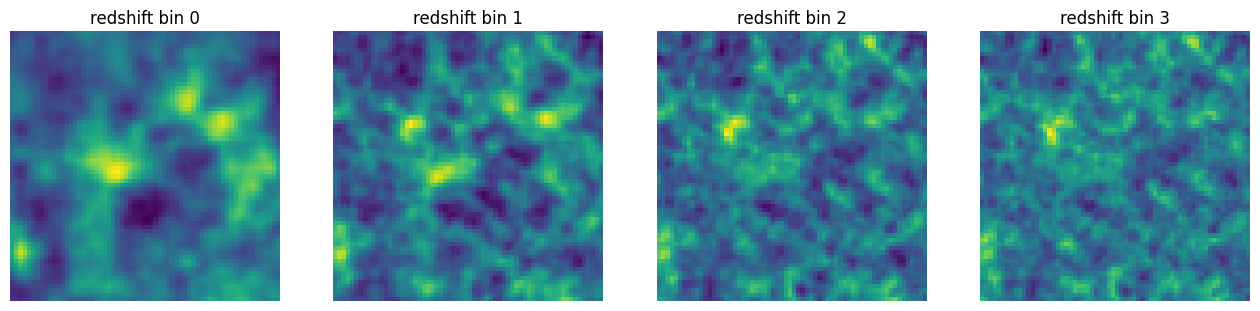

In [4]:
plt.figure(figsize=[16,4])
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title('redshift bin %d'%i)
    plt.imshow(model_trace['kappa_%d'%i]['fn'].mean)
    plt.axis('off')

### Data Generation

In [5]:
######## DATA GENERATION ########
@jax.jit
@jax.vmap
def get_data(key):
    seeded_model = numpyro.handlers.seed(model, key)
    model_trace = numpyro.handlers.trace(seeded_model).get_trace()
    kmap = jnp.stack(
        [
            model_trace["kappa_0"]["value"],
            model_trace["kappa_1"]["value"],
            model_trace["kappa_2"]["value"],
            model_trace["kappa_3"]["value"],
        ],
        axis=-1,
    ).astype("float32")
    theta = jnp.stack([model_trace["Omega_c"]["value"], model_trace["sigma8"]["value"]])

    return theta, kmap

def make_power_sepctrum(nbins, map_size, mass_map):
    l_edges_kmap= np.linspace(50, 1000, 10)

    ps = []
    # power spectrum of the map
    for i, j in itertools.combinations_with_replacement(range(nbins), 2):
        ps_ij = ConvergenceMap(mass_map[:, :, i], angle=map_size * u.deg).cross(
            ConvergenceMap(mass_map[:, :, j], angle=map_size * u.deg),
            l_edges=l_edges_kmap,
        )[1]

        ps.append(ps_ij)
        
    ps = jnp.array(ps)

    return ps


# build train dataset

from tqdm import tqdm 

params_train = []
spectra_train = []
masterkey = jax.random.PRNGKey(42)
bs = 45

for i in tqdm(range(7_000)):
  key, masterkey = jax.random.split(masterkey)
  params, kmap = get_data(jax.random.split(key, bs))
  for k in range(bs):
    ps = make_power_sepctrum(nbins, field_size, kmap[k])
    spectra_train.append(ps)
  params_train.append(params)

params_train = np.stack(params_train).reshape([-1,2])
spectra_train = jnp.array(spectra_train).reshape([len(params_train), -1])

# Normalizing spectra
mu, sigma = spectra_train.mean(axis=0), spectra_train.std(axis=0)
spectra_train_normed = (spectra_train - mu) / sigma

train_ps_dataset = {'theta': params_train, 'x': spectra_train_normed}

del params_train, spectra_train, spectra_train_normed

params_test = []
maps_test = []
masterkey = jax.random.PRNGKey(44)
bs = 20

for i in tqdm(range(100)): 
  key, masterkey = jax.random.split(masterkey)
  params, kmap = get_data(jax.random.split(key, bs))
  params_test.append(params)
  maps_test.append(kmap)

params_test = np.stack(params_test).reshape([-1,2])
maps_test = np.stack(maps_test).reshape([-1,field_npix, field_npix, nbins])
                   
spectra_test = []
N_sample = len(maps_test)
for k in tqdm(range(N_sample)):
    ps = make_power_sepctrum(nbins, field_size, maps_test[k])
    spectra_test.append(ps)

spectra_test = jnp.array(spectra_test).reshape([N_sample, -1])
spectra_test_normed = (spectra_test - mu) / sigma

test_ps_dataset = {'theta': params_test, 'x': spectra_test_normed}

del params_test, maps_test, spectra_test_normed, spectra_test

# normed spectra for the fiducial map as well
m_data_ps = make_power_sepctrum(nbins, field_size, m_data)
true_spectra = m_data_ps.reshape([-1])
true_spectra_normed = (true_spectra - mu) / sigma


with open('true_spectra_normed.pkl', 'wb') as fp:
    pickle.dump(true_spectra_normed, fp)
    
with open('test_ps_dataset.pkl', 'wb') as fp:
    pickle.dump(test_ps_dataset, fp)
    
with open('train_ps_dataset.pkl', 'wb') as fp:
    pickle.dump(train_ps_dataset, fp)

### Inference

In [6]:
######## NDE ARCHITECTURE ########
# Affine bijection used in the RealNVP coupling
bijector_ps = partial(
  AffineCoupling,
  layers=[128] * 6,
  activation=jax.nn.silu
)

# Normalizing Flow with 4 RealNVP coupling layers
NF_ps = partial(
  ConditionalRealNVP,
  n_layers=5,
  bijector_fn=bijector_ps
)


# log probability of the NDE
nf_logp_ps = hk.without_apply_rng(
    hk.transform(
        lambda theta,y : NF_ps(nb_params_to_infer)(y).log_prob(theta).squeeze()
    )
)

# sampling of the NDE
nf_sample_ps = hk.transform(
  lambda y : NF_ps(nb_params_to_infer)(y).sample(100_000, seed=hk.next_rng_key())
)

In [7]:
######## TRAINING ########
summary_stat_dim = len(true_spectra_normed)
nb_params_to_infer = dim
batch_size = 128

dataset1 = train_ps_dataset
dataset2 = test_ps_dataset

# negative log likelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nf_logp_ps.apply(params, mu, batch))

# update function
@jax.jit
def update(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_nll)(
        params,
        mu,
        batch,
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

# init nf params
params_ps = nf_logp_ps.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.ones([1, nb_params_to_infer]),
    0.5 * jnp.ones([1, summary_stat_dim])
)

# learning rate
total_steps = 60_000
nb_steps = total_steps 

lr_scheduler = optax.exponential_decay(
        init_value=1e-3,
        transition_steps=nb_steps // 50,
        decay_rate=0.9,
        end_value=1e-5,
)

# define optimizer
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_ps = optimizer.init(params_ps)


# training
from tqdm import tqdm

batch_loss = []
batch_loss_train = []
batch_loss_test = []
pbar = tqdm(range(total_steps))

for batch in pbar:
    inds = np.random.randint(0, len(dataset1['theta']), batch_size)

    l, params_ps, opt_state_ps = update(
      params_ps,
      opt_state_ps,
      dataset1['theta'][inds],
      dataset1["x"][inds],
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")
    
    if batch % 1000 == 0 :
        inds2 = np.random.randint(0, len(dataset2['theta']), batch_size)
        l_test, _, _ = update(
          params_ps,
          opt_state_ps,
          dataset2['theta'][inds2],
          dataset2["x"][inds2],
        )
        batch_loss_test.append(l_test)
        batch_loss_train.append(l)
        # save params
        with open(f"./save_params/PS_params_nd_batch{batch}.pkl", "wb") as fp:
            pickle.dump(params_ps, fp)

        with open(f"./save_params/PS_opt_state_batch{batch}.pkl", "wb") as fp:
            pickle.dump(opt_state_ps, fp)

loss -3.344: 100%|██████████| 60000/60000 [05:12<00:00, 191.95it/s]


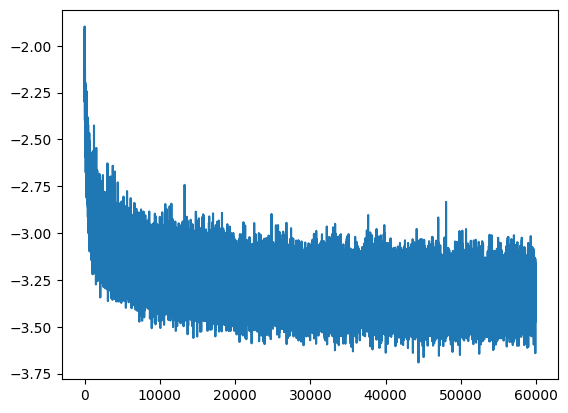

In [8]:
plt.plot(batch_loss[100:])

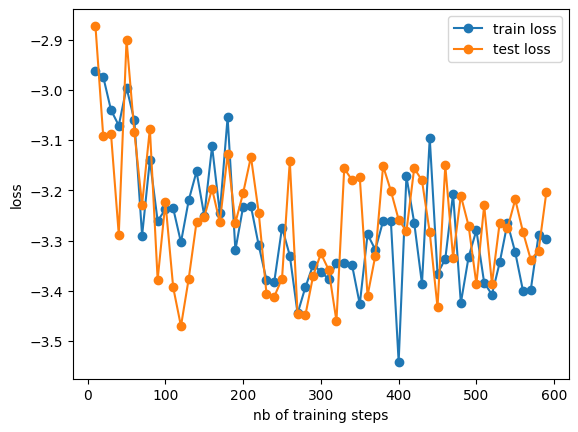

In [9]:
X = jnp.arange(0,len(batch_loss_test))*10
plt.plot(X[1:],batch_loss_train[1:], label ='train loss', marker = 'o')
plt.plot(X[1:],batch_loss_test[1:], label ='test loss', marker='o')
plt.xlabel('nb of training steps')
plt.ylabel('loss')
plt.legend()
plt.savefig('losses_compressor.png')

### Results

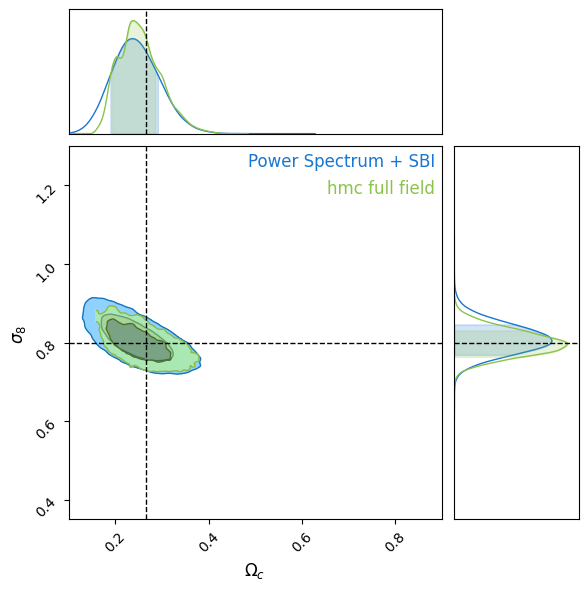

In [11]:
# plot infered params
from chainconsumer import ChainConsumer


LPTPorqueres2023_full_field_hmc = jnp.load('LPTPorqueres2023_full_field_hmc.npy')


c = ChainConsumer()


posterior_ps = nf_sample_ps.apply(
      params_ps,
      rng = jax.random.PRNGKey(54),
      y = true_spectra_normed * jnp.ones([100_000, summary_stat_dim])
)


c.add_chain(
    posterior_ps,
    shade_alpha = 0.5,
    name='Power Spectrum + SBI',
    parameters=['$\Omega_c$','$\sigma_8$']
)

c.add_chain(
    LPTPorqueres2023_full_field_hmc,
    shade_alpha = 0.5,
    parameters=['$\Omega_c$','$\sigma_8$'],
    name='hmc full field',
)


fig = c.plotter.plot(figsize=2.,truth=truth, extents={"$\Omega_c$": (0.1,0.9), "$\sigma_8$": (0.35,1.3)})

In [ ]:
jnp.save('LPTPorqueres2023_powerspectrum_analysis.npy', posterior_ps)